In [13]:
import pickle

with open("go_stanford/no1vc_7_0/traj_data.pkl","rb")  as file:
    payload=pickle.load(file)
print(payload)

{'position': array([[-0.0198973484935508, -0.00011209384996828948],
       [0.006394549385122274, 0.0003751397103882116],
       [0.034817614333259916, -6.888448491381381e-05],
       [0.0864858460593029, -0.0048013718559973065],
       [0.20651056016881933, -0.018688705097039737],
       [0.33525200754954954, -0.030023824174396804],
       [0.45853764098531297, -0.047109188326746085],
       [0.5287817887130783, -0.08185143643556114],
       [0.5721724403014754, -0.13105115659739566],
       [0.5918661376868491, -0.22104753927343748],
       [0.5748625310227278, -0.3169251887738504],
       [0.5607219015977607, -0.4031981837752566],
       [0.5444530426930928, -0.509993469372449],
       [0.535309568515832, -0.6190323516058622],
       [0.5356278780619169, -0.7433806725196421],
       [0.5461119649886008, -0.8465647309858378],
       [0.5710052497526072, -0.9530600177194931],
       [0.6070981946077059, -1.0683737882362025],
       [0.6429996247676177, -1.180766238449019],
       [0.6

In [14]:
import numpy as np
import yaml
from typing import Tuple
from types import SimpleNamespace
import math
MAX_V = 5.55
MAX_W = math.pi/2
DT = 0.05
# RATE = 60
EPS = 1e-8


def clip_angle(theta):
	"""Clip angle to [-pi, pi]"""
	theta %= 2 * np.pi
	if -np.pi < theta < np.pi:
		return theta
	return theta - 2 * np.pi
      

def pd_controller(waypoint: np.ndarray):
	"""PD controller for the robot"""
	assert len(waypoint) == 2 or len(waypoint) == 4, "waypoint must be a 2D or 4D vector"
	if len(waypoint) == 2:
		dx, dy = waypoint
	else:
		dx, dy, hx, hy = waypoint
	# this controller only uses the predicted heading if dx and dy near zero
	if len(waypoint) == 4 and np.abs(dx) < EPS and np.abs(dy) < EPS:
		v = 0
		w = clip_angle(np.arctan2(hy, hx))/DT		
	elif np.abs(dx) < EPS:
		v =  0
		w = np.sign(dy) * np.pi/(2*DT)
	else:
		v = dx / DT
		w = np.arctan(dy/dx) / DT
	v = np.clip(v, 0, MAX_V)
	w = np.clip(w, -MAX_W, MAX_W)
	return v, w




In [15]:
args = SimpleNamespace(
model="gnm_large",
close_threshold=3,
radius=2,
waypoint=2,
goal_node=-1
)

In [16]:
# ROS
import rospy
from sensor_msgs.msg import Image
from std_msgs.msg import Bool, Float32MultiArray

import torch
from PIL import Image as PILImage
import numpy as np
import os
import argparse
import yaml
# UTILS
from deployment.src.utils import msg_to_pil, to_numpy, transform_images, load_model

MODEL_WEIGHTS_PATH = "deployment/model_weights"
MODEL_CONFIG_PATH = "deployment/config/models.yaml"
# DEFAULT MODEL PARAMETERS (can be overwritten by model.yaml)
model_params = {
    "path": "latest.pth", # path of the model in ../model_weights
    "model_type": "gnm", # gnm (conditioned), stacked, or siamese
    "context": 5, # number of images to use as context
    "len_traj_pred": 5, # number of waypoints to predict
    "normalize": True, # bool to determine whether or not normalize images
    "image_size": [85, 64], # (width, height)
    "normalize": True, # bool to determine whether or not normalize the waypoints
    "learn_angle": True, # bool to determine whether or not to learn/predict heading of the robot
    "obs_encoding_size": 1024, # size of the encoding of the observation [only used by gnm and siamese]
    "goal_encoding_size": 1024, # size of the encoding of the goal [only used by gnm and siamese]
    "obsgoal_encoding_size": 2048, # size of the encoding of the observation and goal [only used by stacked model]
}

# GLOBALS
context_queue = []

# Load the model (locobot uses a NUC, so we can't use a GPU)
device = torch.device("cuda")    
topomap_dir = f"carla_trajectories/0"
num_nodes = len(os.listdir(topomap_dir))-2
topomap = []
for i in range(0,num_nodes):
    image_path = os.path.join(topomap_dir, f"{i}.jpg")
    topomap.append(PILImage.open(image_path))

# load model parameters
with open(MODEL_CONFIG_PATH, "r") as f:
    model_config = yaml.safe_load(f)
for param in model_config:
    model_params[param] = model_config[param]

# load model weights
model_filename = model_config[args.model]["path"]
model_path = os.path.join(MODEL_WEIGHTS_PATH, model_filename)
if os.path.exists(model_path):
    print(f"Loading model from {model_path}")
else:
    raise FileNotFoundError(f"Model weights not found at {model_path}")
model = load_model(
    model_path,
    model_params["model_type"],
    model_params["context"],
    model_params["len_traj_pred"],
    model_params["learn_angle"], 
    model_params["obs_encoding_size"], 
    model_params["goal_encoding_size"],
    model_params["obsgoal_encoding_size"],
    device,
)
model.eval()



closest_node = 0
# assert -1 <= args.goal_node < len(topomap), "Invalid goal index"
# if args.goal_node == -1:
#     goal_node = len(topomap) - 1
# else:
#     goal_node = args.goal_node
goal_node=len(topomap)-1
reached_goal = False

# navigation loop

Loading model from deployment/model_weights/gnm_large.pth


In [17]:
closest_node=0
def callback_obs(obs_img):
    if len(context_queue) < model_params["context"] + 1:
        context_queue.append(obs_img)
    else:
        context_queue.pop(0)
        context_queue.append(obs_img)
    

def main():
    if len(context_queue) > model_params["context"]:
        global closest_node
        start = max(closest_node - args.radius, 0)
        end = min(closest_node + args.radius + 1, goal_node)
        distances = []
        waypoints = []
        for sg_img in topomap[start: end + 1]:
            transf_obs_img = transform_images(context_queue, model_params["image_size"]).to(device)
            transf_sg_img = transform_images(sg_img, model_params["image_size"]).to(device)
            dist, waypoint = model(transf_obs_img, transf_sg_img) 
            distances.append(to_numpy(dist[0]))
            waypoints.append(to_numpy(waypoint[0]))
        # look for closest node
        closest_node = np.argmin(distances)
        # chose subgoal and output waypoints
        if distances[closest_node] > args.close_threshold:
            chosen_waypoint = waypoints[closest_node][args.waypoint]
        else:
            chosen_waypoint = waypoints[min(
                closest_node + 1, len(waypoints) - 1)][args.waypoint]
        if model_params["normalize"]:
            chosen_waypoint[:2] *= (MAX_V * DT)
        # closest_node += start
        if closest_node==goal_node: 
           print(f'Goal Reached',closest_node==goal_node)
        print("Closest Node",closest_node)
        return pd_controller(chosen_waypoint)
    return 0.0,0.0



In [18]:
gnm_w=[]
gnm_v=[]
x=[]
for i in range(5):
    callback_obs(PILImage.open(image_path))
for i in range(num_nodes):
    print("obs",i)
    x.append(i)
    image_path = os.path.join(topomap_dir, f"{i}.jpg")
    callback_obs(PILImage.open(image_path))
    values = main()
    if values is not None:
        v,w=values
        gnm_w.append(w)
        gnm_v.append(v)


obs 0
Closest Node 0
obs 1
Closest Node 1
obs 2
Closest Node 2
obs 3
Closest Node 3
obs 4
Closest Node 3
obs 5
Closest Node 4
obs 6
Closest Node 4
obs 7
Closest Node 5
obs 8
Closest Node 5
obs 9
Closest Node 5
obs 10
Closest Node 5
obs 11
Closest Node 1
obs 12
Closest Node 3
obs 13
Closest Node 4
obs 14
Closest Node 5
obs 15
Closest Node 5
obs 16
Closest Node 5
obs 17
Closest Node 1
obs 18
Closest Node 4
obs 19
Closest Node 3
obs 20
Closest Node 2
obs 21
Closest Node 1
obs 22
Closest Node 4
obs 23
Closest Node 5
obs 24
Closest Node 5
obs 25
Closest Node 5
obs 26
Closest Node 5
obs 27
Closest Node 5
obs 28
Closest Node 5
obs 29
Closest Node 4
obs 30
Closest Node 1
obs 31
Closest Node 0
obs 32
Closest Node 0
obs 33
Closest Node 0
obs 34
Closest Node 1
obs 35
Closest Node 2
obs 36
Closest Node 5
obs 37
Closest Node 2
obs 38
Closest Node 2
obs 39
Closest Node 0
obs 40
Closest Node 1
obs 41
Closest Node 2
obs 42
Closest Node 5


In [58]:
import json
with open("carla_trajectories/0/traj_data.json") as file:
    gt=json.load(file)

In [59]:
def rmse(predictions,targets):
    return np.sqrt(np.mean((predictions-targets)**2))

0.6768506430337601
le 43 43 43


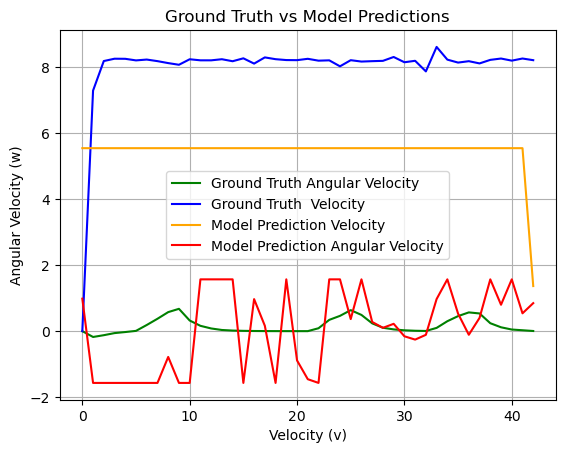

RMSE for Omega 1.2302552173200254
RMSE for Velocity 2.9104631426908374


In [60]:
import matplotlib.pyplot as plt
# plt.plot(x, gt["v"], label='Ground Truth Velocity', color='blue')
print(max(gt["w"]))
print("le",len(gt["w"]),len(gnm_v),num_nodes)
plt.plot(x[:len(gt["w"])], gt["w"], label='Ground Truth Angular Velocity', color='green')
plt.plot(x, gt["v"], label='Ground Truth  Velocity', color='blue')

plt.plot(x, gnm_v, label='Model Prediction Velocity', color='orange')
plt.plot(x, gnm_w, label='Model Prediction Angular Velocity', color='red')

plt.xlabel('X-axis Variable')
plt.ylabel('Values')

plt.xlabel('Velocity (v)')
plt.ylabel('Angular Velocity (w)')
plt.title('Ground Truth vs Model Predictions')
plt.legend()
plt.grid(True)
plt.show()
print("RMSE for Omega",rmse(np.array(gnm_w),np.array(gt["w"])))
print("RMSE for Velocity",rmse(np.array(gnm_v),np.array(gt["v"])))